# Classificando dígitos escritos à mão

## 0. Carregando as bibliotecas necessárias

In [1]:
using DelimitedFiles
using Plots
using Random
using Statistics: mean

## 1. Obtendo e preparando os dados 

### 1.1. Lendo os arquivos (databases) que contêm os dados

In [2]:
train_dataset = readdlm("./MNIST/mnist_train.csv", ',', Float64, '\n'; header=true)
train_dataset = reshape(train_dataset[1], 60000, 785)

test_dataset = readdlm("./MNIST/mnist_test.csv", ',', Float64, '\n'; header=true)
test_dataset = reshape(test_dataset[1], 10000, 785)

# Imagens 28x28 = 784 pixels + 1 coluna para definir o dígito

10000×785 Matrix{Float64}:
 7.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 9.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 9.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 6.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 9.0  0.0  0.0  0.0  0.0  0.0  0.0  0

### 1.2. Definido os conjuntos X e Y de treinamento e de teste

In [3]:
digito_0 = 7.0 # dígito correspondente à "classe zero"
digito_1 = 4.0 # dígito correspondente à "classe um"

idx_digito_0_train = train_dataset[:,1] .== digito_0 # linhas do conjunto de treinamento que contêm o dígito da "classe zero"
idx_digito_1_train = train_dataset[:,1] .== digito_1 # linhas do conjunto de treinamento que contêm o dígito da "classe um"
idx_digito_0_test = test_dataset[:,1] .== digito_0 # linhas do conjunto de teste que contêm o dígito da "classe zero"
idx_digito_1_test = test_dataset[:,1] .== digito_1 # linhas do conjunto de teste que contêm o dígito da "classe um"

10000-element BitVector:
 0
 0
 0
 0
 1
 0
 1
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 1
 0
 0

In [4]:
X_train = [ transpose(train_dataset[idx_digito_0_train,2:end] ./ 255.0) transpose(train_dataset[idx_digito_1_train,2:end] ./ 255.0) ]
X_test = [ transpose(test_dataset[idx_digito_0_test,2:end] ./ 255.0) transpose(test_dataset[idx_digito_1_test,2:end] ./ 255.0)]

Y_train = transpose([ zeros(size(train_dataset[idx_digito_0_train,2:end], 1))..., ones(size(train_dataset[idx_digito_1_train,2:end],1))... ])
Y_test =  transpose([ zeros(size(test_dataset[idx_digito_0_test,2:end], 1))..., ones(size(test_dataset[idx_digito_1_test,2:end],1))... ])

println(size(X_train))
println(size(X_test))
println(size(Y_train))
println(size(Y_test))

(784, 12107)
(784, 2010)
(1, 12107)
(1, 2010)


### 1.3. Explorando um pouco o conjunto de dados

In [ ]:
smpl = 10000
println("Este dígito pertence à classe ", Y_train[1,smpl])
heatmap(transpose(reshape(X_train[:,smpl], 28, 28)); yflip=true)

## 2. estrutura da rede neural

In [5]:
linear(x) = x
d_linear(x) = 1.0

sigmoid(x) = 1 / (1 + exp(-x))
d_sigmoid(x) = sigmoid(x) * (1 - sigmoid(x))

#tanh(x) o julia ja sabe
d_tanh(x) = 1 - tanh(x)^2

function predict(
        X, # Matrizona de dados (m x n), m covariáveis e n amostras
        W, # Matrizona de pesos das combinações lineares (d x m), d neurônios na cada atual e m na camada anterior
        B, # Vetorzão coluna de coef lienares das combinações (d elementos), d neurônios
        f_a # Função de ativação
    )
    return sum(f_a.(W * X .+ B); dims=1)
end

function accuracy(W, B, X, Y, f_a)
    Y_Predictions = predict(X, W, B, f_a)
    acc = mean([ el > 0.5 ? 1 : 0 for el in Y_Predictions ] .== Y)
    return(acc)
end

accuracy (generic function with 1 method)

In [6]:
function computar_gradiente(X, Y, W, B, f_a, df_a)
    
    N_neurons, N_inputs = size(W) # como W é uma matriz, size(W) retorna (N_linhas, N_colunas))
    N_amostras = size(X,2) # como X é uma matriz, size(X, 2) retorna N_colunas)
    
    dW = zeros(N_neurons, N_inputs)
    dB = zeros(N_neurons)
    loss = 0.0

    for amostra in 1:N_amostras # para cada amostra
        
        erro = sum(f_a.(W * X[:, amostra] .+ B)) - Y[1, amostra] # o erro é a diferença entre o valor real e o valor obtido
                
        for neuron in 1:N_neurons # para cada neuron
            
            for input in 1:N_inputs # para cada input
                
                @views dW[neuron, input] += (2/N_amostras) * erro * df_a(W[neuron, :]' * X[:,amostra] + B[neuron]) * X[input,amostra]
                
            end # para cada input
            
            @views dB[neuron] += (2/N_amostras) * erro * df_a(W[neuron, :]' * X[:,amostra] + B[neuron])
            
        end # para cada neuron
        
        loss += 1/N_amostras * erro^2
        
    end #para cada amostra
    
    #println(dW)
    #println(dB)
    
    return dW, dB, loss
    
end

computar_gradiente (generic function with 1 method)

In [9]:
function treinar_rede_neural_2_comgrafico(
        X_train, Y_train, # conjunto de treinamento
        X_test, Y_test, # conjunto de teste
        W0, B0, # parâmetros da rede
        grad_loss, # função que computa o gradiente
        f_a, df_a, # função de ativação e sua derivada
        mu, n_iters, batch_size # hiperparâmetros do modelo
        )
    
    W = W0
    B = B0
    losses = zeros(n_iters)
    train_accs = zeros(n_iters)
    test_accs = zeros(n_iters)  
  
    for iteration in 1:n_iters
        
        batch_idx = randperm(size(X_train,2))[1:batch_size] # selectionando as amostras do batch
        
        dW, dB, losses[iteration] = grad_loss(X_train[:, batch_idx], Y_train[:, batch_idx], W, B, f_a, df_a) # computando os gradientes
        
        W -= mu * dW # atualizando W conforme seus gradientes
        B -= mu * dB # atualizando B conforme seus gradientes
        
        train_accs[iteration] = accuracy(W, B, X_train, Y_train, f_a)
        test_accs[iteration] = accuracy(W, B, X_test, Y_test, f_a)

        ##### Para plotar a "loss" ao longo das iterações...
        #
        loss_i = round(losses[iteration]; digits = 6)
        train_acc_i = round(train_accs[iteration]; digits = 6)
        test_acc_i = round(test_accs[iteration]; digits = 6)
         
        IJulia.clear_output(true)
        loss_plot = scatter(
            [1:10:iteration], losses[1:10:iteration];
            labels = "Loss",
            yscale=:log10,
            xlabel="iteration",
            ylabel="training loss",
            title="iteration $iteration, loss = $loss_i, tr. acc. = $train_acc_i, ts. acc. = $test_acc_i",
            titlefontsize=10
            )
        display(loss_plot)
        #
        #####
        
    end
    
    return(W, B, losses)
end

treinar_rede_neural_2_comgrafico (generic function with 1 method)

## Realizando o treinamento

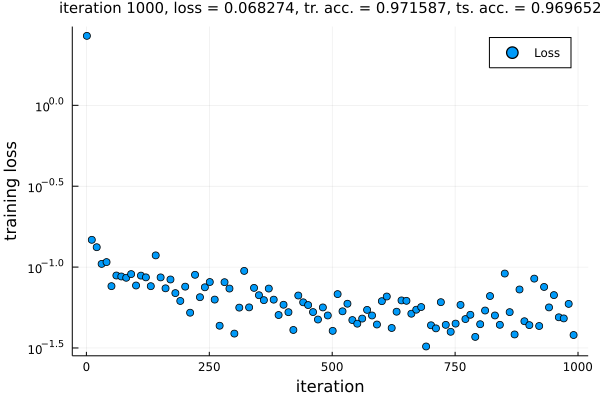

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-0.7567598517153422, -0.7567598517153422, -0.7567598517153422, -0.7567598517153422], [2.6875, 0.2741611430147021, 0.30131630967337486, 0.2711700788847646, 0.24973786462068745, 0.1846765950642803, 0.23853748118553236, 0.1514156645764116, 0.1908722078586801, 0.15546248695378354  …  0.03802948976033261, 0.05277178864840917, 0.05251537703452913, 0.03790940696487435, 0.05622545053379223, 0.05424947655523957, 0.04631699622182605, 0.048393251981431, 0.07486216189251209, 0.0682737116686511])

In [10]:
W = zeros(4,784)
B = zeros(4)

#@show(W, B, accuracy(W, B, X_train, Y_train, sigmoid))

mu = 0.1
n_iters = 1000

W, B, losses = treinar_rede_neural_2_comgrafico(
    X_train,Y_train,X_test,Y_test,
    W, B, computar_gradiente, sigmoid, d_sigmoid, mu, n_iters, 64)

In [ ]:
findall([ el > 0.5 ? 1 : 0 for el in predict(X_test, W, B, sigmoid) ] .!= Y_test)

## Observando o resultado do treinamento

Este dígito foi estimado como [0.25161082363780296]


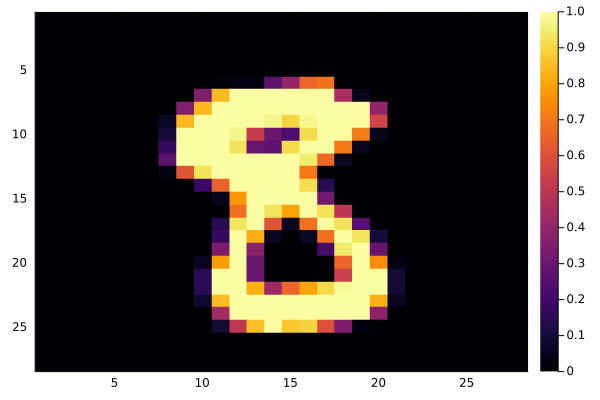

In [9]:
X_alexandre = transpose(test_dataset[test_dataset[:,1] .== 8.0, 2:end] ./ 255.0)

smpl = 150
println("Este dígito foi estimado como ", predict(X_alexandre[:,smpl], W, B, sigmoid))
heatmap(transpose(reshape(X_alexandre[:,smpl], 28, 28)); yflip=true)

Este dígito pertence à classe 1.0e foi estimado como [0.41294299381963057]


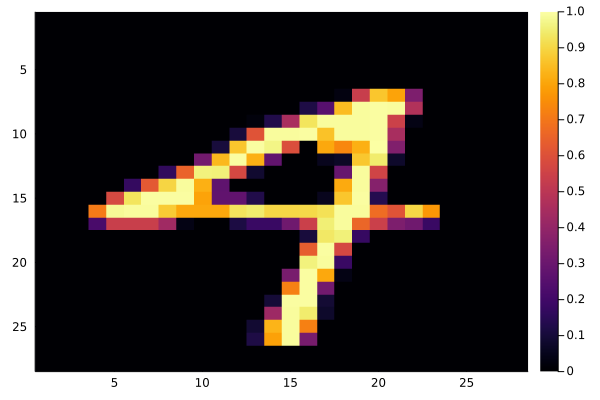

In [10]:
smpl = 1614
println("Este dígito pertence à classe ", Y_test[1,smpl], "e foi estimado como ", predict(X_test[:,smpl], W, B, sigmoid))
heatmap(transpose(reshape(X_test[:,smpl], 28, 28)); yflip=true)

In [ ]:
print(W)

heatmap(
    permutedims(vcat(mapslices(v -> [reshape(v, 28, 28)], W; dims=2)...));
    showaxis=false,
    grid=false,
    transpose=true,
    yflip=true,
    color=:grays,
    aspect_ratio=1.0
)

[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -9.682134305062874e-5 -0.0006027909422184305 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0002599474253283245 -0.0010381650882113074 -0.0013178029197464585 0.0007135441115029915 0.002022242054216855 0.0008515340663352228 1.3598390033608581e-5 -0.0011919958280214888 -0.0007211813487043098 -2.907724264364473e-6 -4.100100627289404e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.00010950244885832652 0.0009153636139030228 0.0009364180984296044 0.0006587862813159664 0.0018201815187070857 0.0007412187554214747 -0.0003186953432437557 0.0009702437560519763 0.0019355892221723534 0.002571408939745387 0.0019068766014826144 -0.001134787642682771 -0.007767368201661268 -0.006700402932921706 -0.00035910081423384436 0.0026670043394840235 -0.0006221076918125664 -0.0021845402870924297

0.05723407713593883 0.09142432937995956 0.08881816232716945 0.0601631555077573 0.045718395950969236 0.03953663739566165 0.020228647129093433 0.02122143039095977 -0.0025603032058819832 -0.02770263036042896 -0.035725123497513146 -0.016187968490897604 0.00842407966614064 -0.0035396092570350265 0.011150435607772395 0.000677686552486404 -0.003995260400678355 -0.0013346547705819338 -1.241287686137232e-5 -0.00043771884868367154 -2.064155720782842e-6 3.0393478377416744e-6 0.0026437881659681565 0.0020574332767887642 -0.005222020255617709 0.002140737448420695 0.014648952265158546 0.022942183194394422 0.06054991289371199 0.07029716904359165 0.057310030043460934 0.038765940974801176 0.02352495144785006 0.04161681905045283 0.03176171994801022 0.030699368235096995 -0.018447039559717184 -0.03679314239580713 -0.016656281863376577 -0.012289872206414088 -0.003317075724197924 -0.014250988701419094 0.0009087425681559252 0.0020977887575000936 -0.00037619700205828935 -0.0008127456894805639 -4.51377340413538

 0.15633943630250774 0.14752156305878406 0.08469073348157173 0.028640428092707122 0.015477715510102722 0.000535359214710518 0.0021543818427913414 0.007581522428499978 0.0017630254364117423 -0.022264478056850102 -0.01084519809670464 -0.012064783166133875 0.0013817565788159843 -0.003272027515679347 0.0018120179343225702 0.0026306336845647676 0.0 0.0 -0.0012418282998793379 -0.004358883777867074 -0.014574043835045644 0.0006743914606569063 0.03657623218259864 0.06933457609425057 0.08681285813293006 0.08529032058882491 0.08112448843902928 0.09152240637002376 0.13642878225645194 0.12140943197649488 0.08431535495055188 0.01965976714247939 -0.018013468869386436 -0.013531460441062092 0.008754962498525257 5.501869920701482e-5 -0.009954373275101082 -0.01480098746448389 -0.004534809746650172 -0.0029958314452960106 0.003475153475076647 0.0034684005965344273 0.0025908409365369726 0.00039713425735174326 0.0 -2.5352340622411613e-6 4.220552169965314e-6 -0.00029457415565010194 -0.0009144767793341653 0.01